In [1]:
#Code Written by Matthew Miller, adapted from Diana Lewis and chatgpt
import numpy as np
import os
import cv2
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras import layers, models 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Input Images from File to train the model 
# Specify the folder containing the images and CSV file
folder_path = 'Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound'

# Load preprocessed images
images = []
for i in range(30):  # Assuming 30 images starting from 000000
    image_filename = f'enhanced_TRAIN{i:06d}.jpg'  # Zero-padded 6-digit number
    image_path = os.path.join(folder_path, image_filename)
    image = cv2.imread(image_path)
    images.append(image)
    
# Load bounding box labels from CSV file
bounding_box_labels = []
image_filenames = []  # List to store image filenames
csv_file = os.path.join(folder_path, 'Glaucoma30_bounding_boxes_06Apr2024.csv')
with open(csv_file, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # Skip header row
    for row in csvreader:
        # Extract image filename from column 4 (assuming 0-based indexing)
        image_filename = row[3].strip()  # Remove leading/trailing whitespaces
        image_filenames.append(image_filename)  # Add filename to the list
        # Extract bounding box parameters from the "rect" column
        bbox_params = eval(row[5])  # Assuming "rect" is the 6th column
        # Extract individual bounding box parameters from the list of dictionaries
        bbox_dict = bbox_params[0]  # Assuming there's only one dictionary in the list
        x = int(bbox_dict['x'])
        y = int(bbox_dict['y'])
        width = int(bbox_dict['width'])
        height = int(bbox_dict['height'])

        ##### Adjust bounding box parameters (trial and error)
        #x_adjusted = x * 21  # Adjust x-coordinate by adding 10 pixels
        #y_adjusted = y * 10 # Adjust y-coordinate by adding 10 pixels
        #width_adjusted = width * 21  # Adjust width by scaling by a factor of 1.1
        #height_adjusted = height * 10  # Adjust height by scaling by a factor of 1.1
        ##### Add bounding box parameters to the list
        #bounding_box_labels.append([x, y, width, height])
        
        
        
        #Matt found the real way to deal the image image size mismatch
        #label studio just gives the percentages of the overall image size for the bounding box
        #Here's the non trial and error method:
        
        #These are needed to show what image size the boxes have to go back to
        original_width = 2048
        original_height = 1024
        
        
        x_adjusted = int(x / 100.0 * original_width)
        y_adjusted = int(y / 100.0 * original_height)
        width_adjusted = int(width / 100.0 * original_width)
        height_adjusted = int(height / 100.0 * original_height)
        
        
        
        
        
        
        bounding_box_labels.append([x_adjusted, y_adjusted, width_adjusted, height_adjusted])

        # Process bounding box parameters as needed
        # Example: Print adjusted bounding box parameters
        '''print(f"Image: {image_filename}, Adjusted Bounding Box: x={x_adjusted}, y={y_adjusted}, "
                  f"width={width_adjusted}, height={height_adjusted}")
                    '''
# Convert bounding box labels to numpy array
labels = np.array(bounding_box_labels)



In [3]:
# Load bounding box labels from CSV file
csv_file = os.path.join(folder_path, 'Glaucoma30_bounding_boxes_06Apr2024.csv')
with open(csv_file, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # Skip header row
    for row in csvreader:
        # Extract image filename from the 4th column
        image_filename = row[3]  # Assuming image filename is in the 4th column
        print("Image filename from CSV:", image_filename)
        
        # Find the index of the image filename in the list of image filenames
        image_index = [i for i, filename in enumerate(image_filenames) if filename == image_filename]
        print("Index of image filename:", image_index)
        
        # Print the bounding box label corresponding to the image
        bounding_box_label = bounding_box_labels[image_index[0]]
        print("Bounding box label:", bounding_box_label)

Image filename from CSV: enhanced_TRAIN000000.jpg
Index of image filename: [0]
Bounding box label: [245, 235, 327, 368]
Image filename from CSV: enhanced_TRAIN000001.jpg
Index of image filename: [1]
Bounding box label: [1433, 194, 327, 337]
Image filename from CSV: enhanced_TRAIN000002.jpg
Index of image filename: [2]
Bounding box label: [512, 440, 225, 235]
Image filename from CSV: enhanced_TRAIN000003.jpg
Index of image filename: [3]
Bounding box label: [430, 235, 307, 358]
Image filename from CSV: enhanced_TRAIN000004.jpg
Index of image filename: [4]
Bounding box label: [1187, 337, 245, 256]
Image filename from CSV: enhanced_TRAIN000005.jpg
Index of image filename: [5]
Bounding box label: [1249, 378, 266, 286]
Image filename from CSV: enhanced_TRAIN000006.jpg
Index of image filename: [6]
Bounding box label: [1228, 153, 450, 450]
Image filename from CSV: enhanced_TRAIN000007.jpg
Index of image filename: [7]
Bounding box label: [1331, 184, 348, 368]
Image filename from CSV: enhanced_T

In [4]:
# Function to draw bounding boxes on images
def draw_bounding_box(image, bbox):
    x_adjusted, y_adjusted, width_adjusted, height_adjusted = bbox
    # Draw bounding box rectangle on image
    #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.rectangle(image, (x_adjusted, y_adjusted), (x_adjusted + width_adjusted, y_adjusted + height_adjusted), (0, 255, 0), 4)
    return image

# Visualize images with bounding boxes
'''for i in range(len(images)):
    image = images[i].copy()  # Make a copy of the image to avoid modifying the original
    bbox = labels[i]  # Get the bounding box for the current image
    # Draw bounding box on image
    image_with_bbox = draw_bounding_box(image, bbox)
    # Display image with bounding box
    plt.imshow(image_with_bbox)
    plt.title(f"Image {i+1} with Bounding Box")
    plt.axis('off')
    plt.show()
    '''
    
## Matt: FYI these images are showing as blueish instead of redish since you have to display it as BRG instead of RGB.
## Look at some of my other code if you're interested in seeing how you display it correctly
## Leaving it as blue has no impact on the later steps, it's just a matter of how it displays


##use half the width to make a radius and make a circular mask

'for i in range(len(images)):\n    image = images[i].copy()  # Make a copy of the image to avoid modifying the original\n    bbox = labels[i]  # Get the bounding box for the current image\n    # Draw bounding box on image\n    image_with_bbox = draw_bounding_box(image, bbox)\n    # Display image with bounding box\n    plt.imshow(image_with_bbox)\n    plt.title(f"Image {i+1} with Bounding Box")\n    plt.axis(\'off\')\n    plt.show()\n    '

In [5]:
def create_binary_mask(image_shape, bbox):
    mask = np.zeros(image_shape, dtype=np.uint8)
    x, y, width, height = bbox
    mask[y:y+height, x:x+width] = 1
    return mask

def convert_bboxes_to_masks(images, bboxes):
    masks = []
    for image, bbox in zip(images, bboxes):
        mask = create_binary_mask(image.shape[:2], bbox)
        masks.append(mask)
    return masks

# Example usage:
# Assuming X_train contains input images and y_train contains bounding box labels
masks_train = convert_bboxes_to_masks(images, labels)
#masks_val = convert_bboxes_to_masks(X_val, y_val)

'''
for image_mask in masks_train:
    
    plt.imshow(image_mask, cmap='gray')  # Display the mask as a grayscale image
    plt.title('Mask Image')
    plt.colorbar()  # Add color bar to show pixel intensity values
    plt.show()
    
    
    '''

"\nfor image_mask in masks_train:\n    \n    plt.imshow(image_mask, cmap='gray')  # Display the mask as a grayscale image\n    plt.title('Mask Image')\n    plt.colorbar()  # Add color bar to show pixel intensity values\n    plt.show()\n    \n    \n    "

In [6]:
#print(len(images))
print(len(masks_train))
type(masks_train[0])

30


numpy.ndarray

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 262s 61s/step - accuracy: 0.5469 - loss: 32.5103 - val_accuracy: 0.9355 - val_loss: 1.5339 - learning_rate: 0.0010
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1393s 450s/step - accuracy: 0.6686 - loss: 3.8100 - val_accuracy: 0.8915 - val_loss: 2.2567 - learning_rate: 0.0010
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 216s 54s/step - accuracy: 0.6400 - loss: 9.8132 - val_accuracy: 0.9119 - val_loss: 1.6154 - learning_rate: 0.0010
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1429s 458s/step - accuracy: 0.8834 - loss: 2.4129 - val_accuracy: 0.8117 - val_loss: 0.6367 - learning_rate: 0.0010
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 215s 54s/step - accuracy: 0.8288 - loss: 1.6058 - val_accuracy: 0.3527 - val_loss: 2.2784 - learning_rate: 0.0010


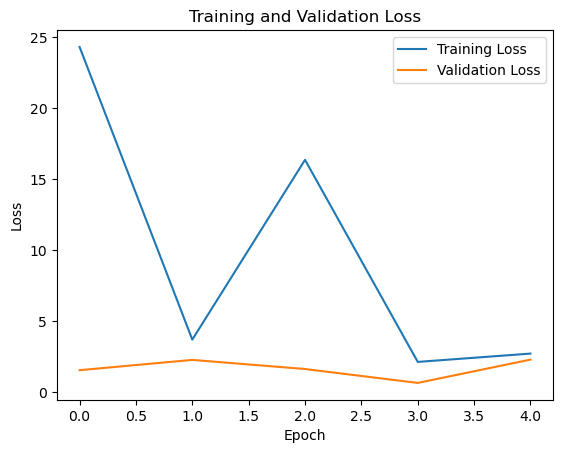

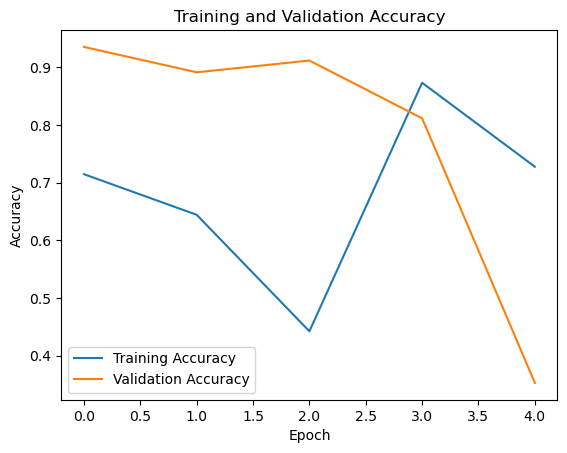

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def gnet_cup(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(34, (4, 2), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(34, (4, 2), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)

    conv2 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(4, 4))(conv2)

    conv3 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(4, 4))(conv3)

    conv4 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(4, 4))(conv4)

    conv5 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = UpSampling2D(size=(4, 4))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=(4, 4))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = UpSampling2D(size=(4, 4))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = UpSampling2D(size=(4, 4))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(34, (4, 2), activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(34, (4, 2), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# Example usage
input_shape = (2048, 1024, 3)
num_classes = 1
cup_model = gnet_cup(input_shape, num_classes)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks_train, test_size=0.2, random_state=42)

# Data augmentation
data_gen_args = dict(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
                     zoom_range=0.1, horizontal_flip=True, vertical_flip=True, fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Define batch size
batch_size = 5

# Define seed for reproducibility
seed = 1

# Reshape input data
X_train = np.reshape(X_train, (-1, input_shape[0], input_shape[1], input_shape[2]))
X_val = np.reshape(X_val, (-1, input_shape[0], input_shape[1], input_shape[2]))
y_train = np.reshape(y_train, (-1, input_shape[0], input_shape[1], 1)).astype(np.float32)
y_val = np.reshape(y_val, (-1, input_shape[0], input_shape[1], 1)).astype(np.float32)

# Create custom generators for training and validation data
def custom_generator(image_data_generator, mask_data_generator, X, y, batch_size, seed):
    image_generator = image_data_generator.flow(X, batch_size=batch_size, seed=seed)
    mask_generator = mask_data_generator.flow(y, batch_size=batch_size, seed=seed)
    
    # Get an iterator for the generators
    image_iterator = iter(image_generator)
    mask_iterator = iter(mask_generator)
    
    while True:
        try:
            X_batch = next(image_iterator)
            y_batch = next(mask_iterator)
            yield X_batch, y_batch
        except StopIteration:
            # Reset iterators if they reach the end of the data
            image_iterator = iter(image_generator)
            mask_iterator = iter(mask_generator)


train_generator = custom_generator(image_datagen, mask_datagen, X_train, y_train, batch_size, seed)
val_generator = custom_generator(image_datagen, mask_datagen, X_val, y_val, batch_size, seed)

# Train the model

# Compile the model with Adam optimizer and binary cross-entropy loss
opt = Adam(clipvalue=0.5)
cup_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model
history = cup_model.fit(train_generator, steps_per_epoch=len(X_train) // batch_size,
                        validation_data=val_generator, validation_steps=len(X_val) // batch_size,
                        epochs=5, callbacks=[reduce_lr])
# Save the trained model
cup_model.save("ROI_model.h5")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
## apply to new images (use in the main code)